# Notebook to examine rag evaluation results

In [1]:
# Imports
import sys
import pandas as pd
import numpy as np
sys.path.append("../dev/")
sys.path.append("../src/")
import time

from csv_helpers import get_csv_files_from_dir

### Analyse and plot the pool results - off all entangled parameter permutations

In [2]:
# Look at the eval results files, especially the mean correctness
import dask.dataframe as dd
# Loop over all eval results files
# Get column names which are the config parameters and the mean correctness or some other metric
def create_df_mean_correctness(dataset,parameter,evaluator, directory):
    columns = [
        "quExp",
        "rerank",
        "cExp",
        "backRev",
        "numRefLim",
        "select",
        "evaluator",
    ] + ["MeanCorrectness"]
    mean_correctness_df = pd.DataFrame(columns=columns)
    # Get file names
    eval_results_file_names = get_csv_files_from_dir(directory)
    # Iterate over all eval results files
    for filename in eval_results_file_names[:]:  # Iterate over all eval results files
        # Filter files: Only look at files with quExp1_rerank1_cExp*_backRevFalse_numRef4
        # first_file = f"{eval_results_dir}/{eval_results_file_names[1]}"  # Slice for dev
        file = eval_results_dir + "/" + filename  # Slice for dev
    
        # Read eval results from CSV
        eval_results_df = dd.read_csv(file)
        # Show the first 5 rows
        
        correctness_values = eval_results_df["Correct"].dropna()
        correctness_values = correctness_values.compute(engine="python")
    
        #print(f"Correctness values: {correctness_values}")
    
        mean = sum(correctness_values) / len(correctness_values)
        
        # Project the values to be between 0 and 1
        mean_scaled = (mean - min(correctness_values)) / (max(correctness_values) - min(correctness_values))

        #print(f"Mean correctness: {mean}")
        # Append the correctness values to the list
        config = filename.split("_")
        #print(f" Config: {config}")
        mean_correctness_df = pd.concat(
            [
                mean_correctness_df,
                pd.DataFrame(
                    [
                        {
                            "quExp": config[0].replace("quExp", ""),
                            "rerank": config[1].replace("rerank", ""),
                            "cExp": config[2].replace("cExp", ""),
                            "backRev": config[3].replace("backRev", ""),
                            "numRefLim": config[4].replace("numRefLim", ""),
                            "select": config[-2],
                            "evaluator": config[-1].replace(".csv", ""),
                            "MeanCorrectness": mean_scaled,
                        }
                    ]
                ),
            ]
        )
    return mean_correctness_df

Analyse parameter significance

/tmp/ipykernel_997980/542158981.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mean_correctness_df = pd.concat(


Dataset: miniBiosQA, 
Evaluator: llm-judge, 
Parameter: pool
Unique values of numRefLim: ['1' '2' '3' '4']
ANOVA result for numRefLim: F-statistic = 1.0040375226814584, p-value = 0.3965635369344865


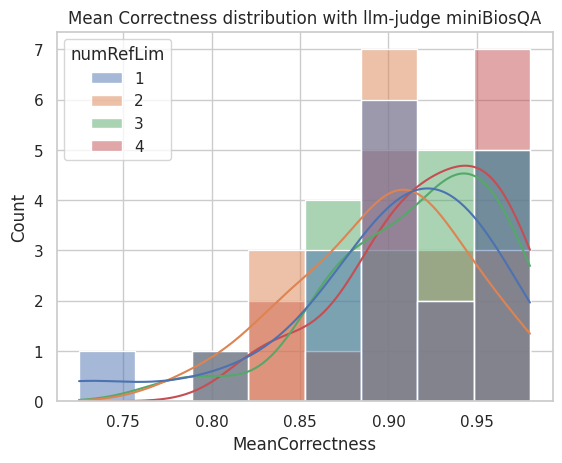

In [59]:
# Extract results wo get insights on parameter significance
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set_theme(style="whitegrid")
sns.set_context("paper")
sns.set_context("talk")
sns.set_context("notebook")

# Set configuration
parameter = "pool" # pool, quExp, rerank, cExp, backRev, numRefLim
evaluator = "llm-judge" # llm-judge, ROUGE-1
dataset = "miniBiosQA" # miniBiosQA, miniWiki
eval_results_dir = f"../parallel_100_rows_eval/{dataset}/{parameter}/{evaluator}"

# Create the dataframe
mean_correctness_df = create_df_mean_correctness(dataset,parameter,evaluator, eval_results_dir)
mean_correctness_df = mean_correctness_df[mean_correctness_df["select"] == "all"]
# mean_correctness_df = mean_correctness_df[mean_correctness_df["rerank"].isin(["True", "rrf"])] 
mean_correctness_df.sort_values(by="MeanCorrectness", ascending=False)
print(f"Dataset: {dataset}, \nEvaluator: {evaluator}, \nParameter: {parameter}")
#sns.histplot(data=mean_correctness_df, x="MeanCorrectness", hue="quExp", kde=True)
#sns.histplot(data=mean_correctness_df, x="MeanCorrectness", hue="rerank", kde=True)
#sns.histplot(data=mean_correctness_df, x="MeanCorrectness", hue="cExp", kde=True)
#sns.histplot(data=mean_correctness_df, x="MeanCorrectness", hue="backRev", kde=True)
#sns.histplot(data=mean_correctness_df, x="MeanCorrectness", hue="numRefLim", kde=True)
#plt.title(f"Mean Correctness distribution with {evaluator} {dataset}")

for rag_method in ["numRefLim"]: #["quExp"]: # ,"rerank","cExp","numRefLim"]:
    # Calcualate the p and f values
    # Shorten the dataframe name
    df = mean_correctness_df
    #Get unique values of the rag method column 
    method_variables = df[rag_method].unique()
    print(f"Unique values of {rag_method}: {method_variables}")
    # One-way ANOVA: Test if the means of 'x' differ across categories in 'a'
    groups = [df[df[rag_method] == variable]['MeanCorrectness'] for variable in method_variables]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"ANOVA result for {rag_method}: F-statistic = {f_stat}, p-value = {p_value}")

    ### Make histplot

    # Make a histplot with respect to the rag method
    sns.histplot(data=mean_correctness_df, x="MeanCorrectness", hue=rag_method, kde=True)
    # Make a line plot with respect to the rag method
    # Plot number of references limit against mean correctness
    # sns.barplot(data=mean_correctness_df, x=rag_method, y="MeanCorrectness")
    # Get p value
    
    # Put p value on the plot nicely
    #plt.text(0.22, 6.5, f"p-value: {round(p_value,3)}\n f-value: {round(f_stat,3)}", fontsize=12)
    plt.title(f"Mean Correctness distribution with {evaluator} {dataset}")
    plt.savefig(f"../plots/{dataset}_{evaluator}_{parameter}_{rag_method}_histplot.png")
    plt.show()
   

## Evaluate gold passages if given

Context matches: 

  queExp rerank   cExp backRev numRefLim  \
0    NaN  False  False   False         5   
0    NaN   True  False   False         5   
0    NaN    rrf  False   False         5   
0    NaN  False  False   False         5   
0    NaN   True  False   False         5   
0    NaN    rrf  False   False         5   
0    NaN  False  False   False         5   
0    NaN   True  False   False         5   
0    NaN    rrf  False   False         5   

                                             matches sum_matches quExp  
0  [2, 2, 1, 1, 1, 5, 2, 3, 1, 0, 2, 1, 1, 1, 2, ...         179     1  
0  [2, 2, 1, 1, 1, 5, 2, 3, 1, 0, 1, 0, 1, 1, 3, ...         210     1  
0  [1, 1, 1, 1, 0, 4, 2, 4, 0, 0, 2, 1, 1, 1, 3, ...         195     1  
0  [2, 1, 1, 1, 0, 2, 1, 3, 1, 0, 2, 1, 1, 1, 2, ...         171     2  
0  [0, 2, 1, 1, 1, 4, 2, 1, 1, 0, 1, 1, 1, 1, 1, ...         151     2  
0  [2, 2, 1, 1, 1, 4, 1, 4, 0, 0, 3, 1, 1, 1, 3, ...         185     2  
0  [2, 2, 1, 1, 1, 3, 1, 2, 0

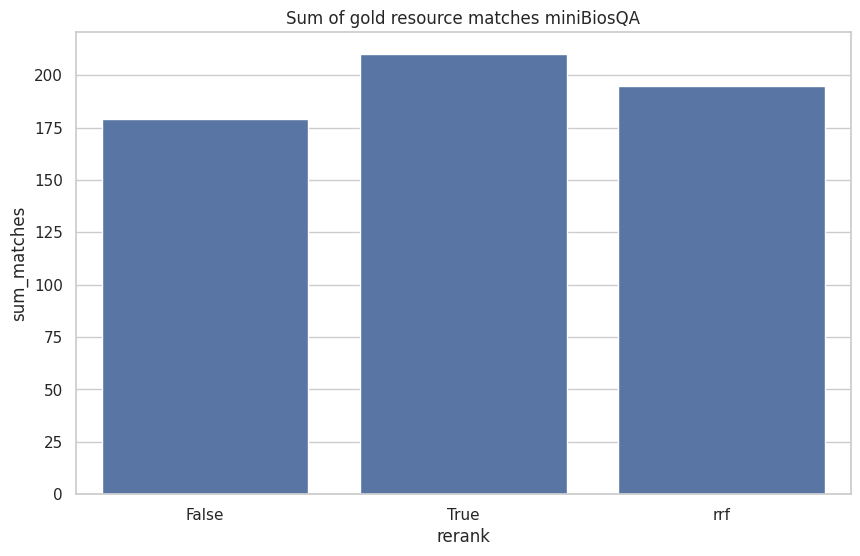

In [35]:
def create_df_goldPassages(dataset,parameter,directory):
    # Column names with the config params and the matches and sum of matches
    columns = [
        "queExp",
        "rerank",
        "cExp",
        "backRev",
        "numRefLim",
    ] + ["matches", "sum_matches"]
    context_id_matches = pd.DataFrame(columns=columns)
    # Get file names
    eval_results_file_names = get_csv_files_from_dir(directory)
    # Iterate over all eval results files
    for filename in eval_results_file_names[:]:  # Iterate over all eval results files
        # Filter files: Only look at files with quExp1_rerank1_cExp*_backRevFalse_numRef4
        # first_file = f"{eval_results_dir}/{eval_results_file_names[1]}"  # Slice for dev
        file = directory + "/" + filename  # Slice for dev
    
        # Read eval results from CSV
        df = pd.read_csv(file)
        # Keep only the 'contexts_ids' and 'goldPassages' columns
        # Calcualte matches between the ids in the two columns
      
        # Account for a row containint no list but a single int
        if isinstance(df["contexts_ids"][0], int):
            df["contexts_ids"] = df["contexts_ids"].apply(lambda row: [row])
        else:
            df["contexts_ids"] = df["contexts_ids"].apply(
                lambda row: [int(row)] if isinstance(row, int) else list(map(int, row.split(", "))) if isinstance(row, str) and row else []
            )
       
        df["goldPassages"] = df["goldPassages"].apply(
            lambda row: list(map(int, row.split(", "))) if row else []
        )
        # Calculate matches between the ids in the two columns
        matches = df.apply(
            lambda row: len(set(row["contexts_ids"]).intersection(row["goldPassages"])),
            axis=1,
        )
        # Add the matches to the DataFrame
        df = df[["contexts_ids", "goldPassages"]]
        # df["matches"] = matches

        # Write the eval results to a csv file
        # eval_results_dir = "./parallel_100_rows_eval"
        # Add param settings and matches to the DataFrame
        # print(f"Param settings: {param_settings}")
        # print(f"Matches \n: {matches.array}")
        # Add the param settings and matches row per row to the DataFrame
        config = filename.split("_")
        context_id_matches = pd.concat(
            [
                context_id_matches,
                pd.DataFrame(
                    [
                        {
                            "quExp": config[0].replace("quExp", ""),
                            "rerank": config[1].replace("rerank", ""),
                            "cExp": config[2].replace("cExp", ""),
                            "backRev":  config[3].replace("backRev", ""),
                            "numRefLim": config[4].replace("numRefLim", ""),
                            "matches": matches.array,
                            "sum_matches": matches.sum(),
                        }
                    ]
                ),
            ]
        )
    return context_id_matches



# Set configuration
parameter = "pool" # pool, quExp, rerank, cExp, backRev, numRefLim
dataset = "miniBiosQA" # miniBiosQA, miniWiki
maxSources = 5
#eval_results_dir = f"../parallel_100_rows_eval/{dataset}/{evaluator}"
pipe_results_dir = f"../parallel_100_rows_pipe/{dataset}/{parameter}"

# Create the dataframe
context_matches_df = create_df_goldPassages(dataset,parameter, pipe_results_dir)

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
print("Context matches: \n")

# Select rows where numRefLim is 5 and cExp is False
context_matches_df = context_matches_df[context_matches_df["numRefLim"] == str(maxSources)]
context_matches_df = context_matches_df[context_matches_df["cExp"] == "False"]
print(context_matches_df)
context_matches_df = context_matches_df[context_matches_df["quExp"] == "1"]
context_matches_df = context_matches_df[["rerank", "sum_matches"]]
print(context_matches_df)
plt.figure(figsize=(10, 6))
# Make a bar plot with the sum of matches
sns.barplot(data=context_matches_df, x="rerank", y="sum_matches")

plt.title(f"Sum of gold resource matches {dataset}")
plt.savefig(f"../plots/{dataset}_{parameter}_gold_resource_matches.png")


In [ ]:
# Get answer and ground_truth of rag elements
from evaluate import ROUGE
from pprint import pprint
answer = "yes"
ground_truth = "yes, however the weather is not good and aspiring to be a good person is not easy. Whis leads to some people being bad."

print(f"Answer: {answer}")
print(f"Ground truth: {ground_truth}")
rouge = ROUGE(answer, ground_truth)
pprint(rouge)
print("\n")


In [ ]:
# Look at filenames 
# Get eval results file names
eval_results_dir = "../eval_results/LLMs/miniWiki"
eval_results_file_names = get_csv_files_from_dir(eval_results_dir)

# Loop over all eval results files and output the filenames with an index in the dir
for i, filename in enumerate(eval_results_file_names[:]):  # Iterate over all eval results files
    print(f"{i}: {filename}")

### RAG Triad

In [36]:
def add_triad_column(df,combination): 
    ## Add a column with the triad sum based on the desired combination
    if combination == "average":
        # Sum the CR, Faithfulness and AR values and put in a new colum called triad sum
        df["CR"] = df["CR"].apply(lambda x: sum(map(float, x.strip('[]').split())) / len(x.strip('[]').split()) if pd.notna(x) else np.nan)
        df["Faithfulness"] = df["Faithfulness"].apply(lambda x: sum(map(float, x.strip('[]').split())) / len(x.strip('[]').split()) if pd.notna(x) else np.nan)
        df["TriadSum"] = (df["CR"] + df["Faithfulness"] + df["AR"]) / 3

    # Take the first element of context relevance, faithfulness and answer relevance
    if combination == "first":
        print(f"Linear combination: {combination}")
        df["CR"] = df["CR"].apply(lambda x: float(x.strip('[]').split()[0]))
        df["Faithfulness"] = df["Faithfulness"].apply(lambda x: float(x.strip('[]').split()[0]))
        df["TriadSum"] = ( df["CR"]* 2 + df["Faithfulness"]* 2 + df["AR"] ) / 3
    
    if combination == "high":
        print(f"Linear combination: {combination}")
        df["CR"] = df["CR"].apply(lambda x: max(map(float, x.strip('[]').split())))
        df["Faithfulness"] = df["Faithfulness"].apply(lambda x: max(map(float, x.strip('[]').split())))
        df["TriadSum"] = ( df["CR"] + df["Faithfulness"] + df["AR"] ) / 3
    return df


File: ../eval_results/triad/quExp1_rerankFalse_cExpFalse_backRevFalse_numRefLim4_LLMllama3.1:latest_all_llm-judge.csv
              TriadSum        CR  Faithfulness        AR   Correct
TriadSum      1.000000  0.911969      0.941342  0.943992  0.835409
CR            0.911969  1.000000      0.839792  0.752623  0.675911
Faithfulness  0.941342  0.839792      1.000000  0.834407  0.760849
AR            0.943992  0.752623      0.834407  1.000000  0.864703
Correct       0.835409  0.675911      0.760849  0.864703  1.000000


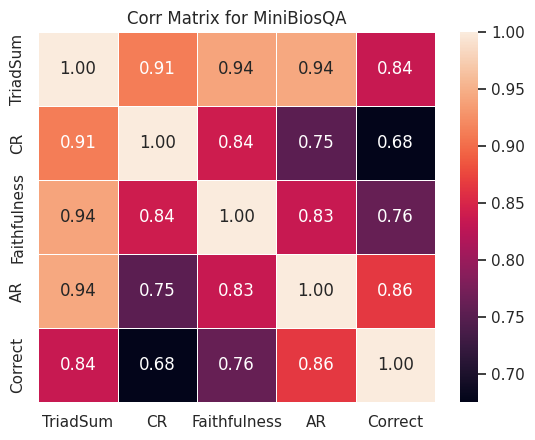

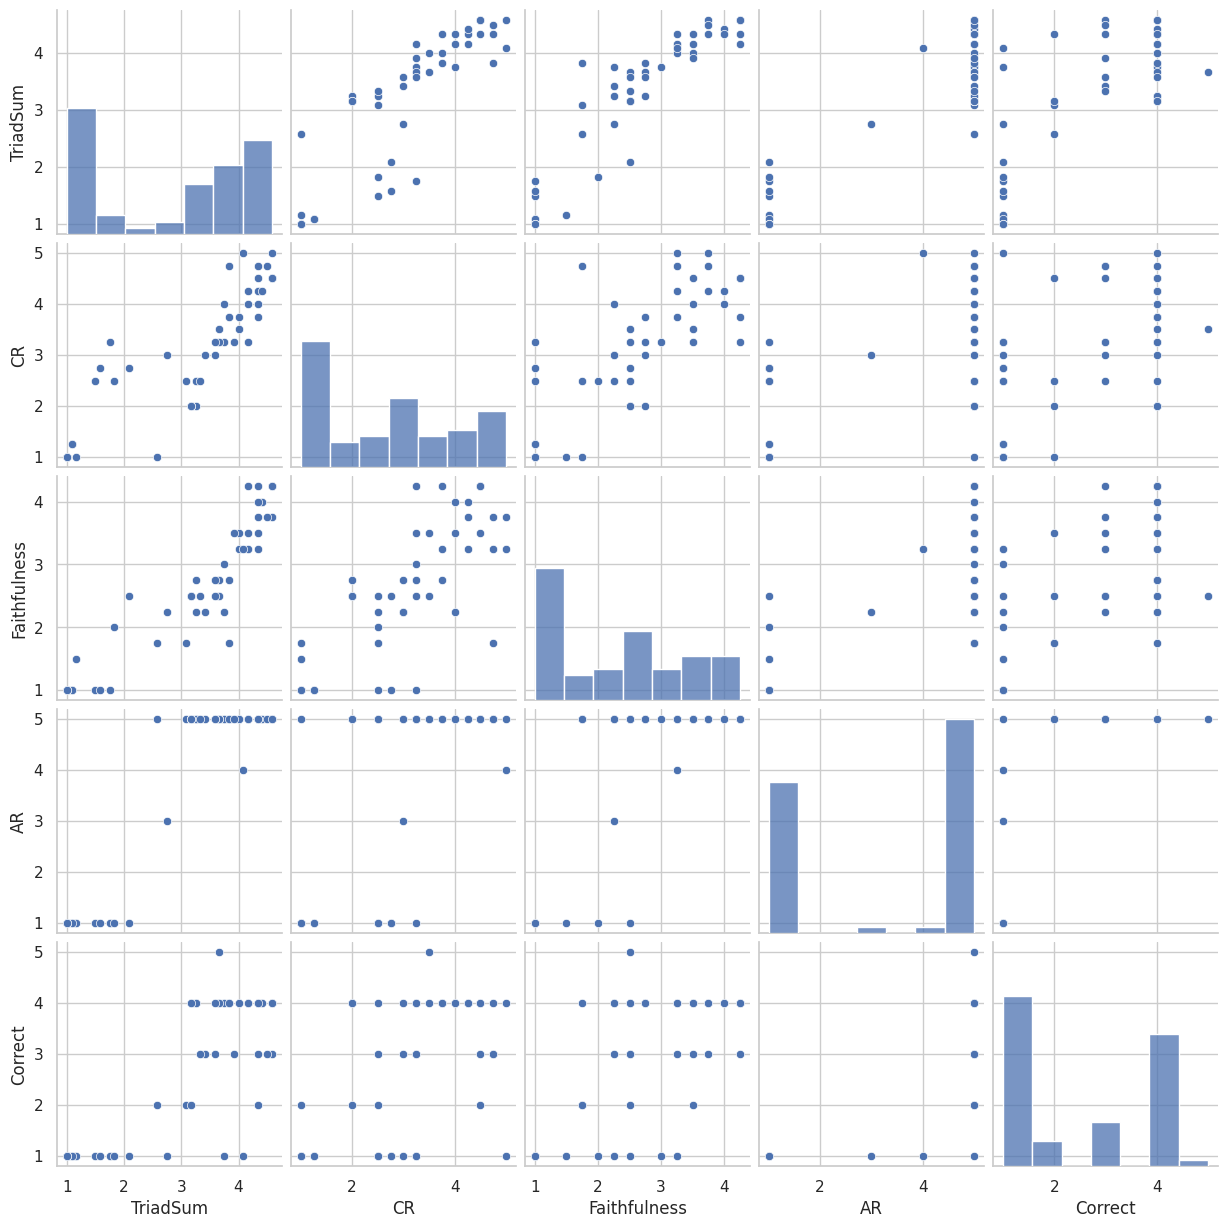

<Figure size 640x480 with 0 Axes>

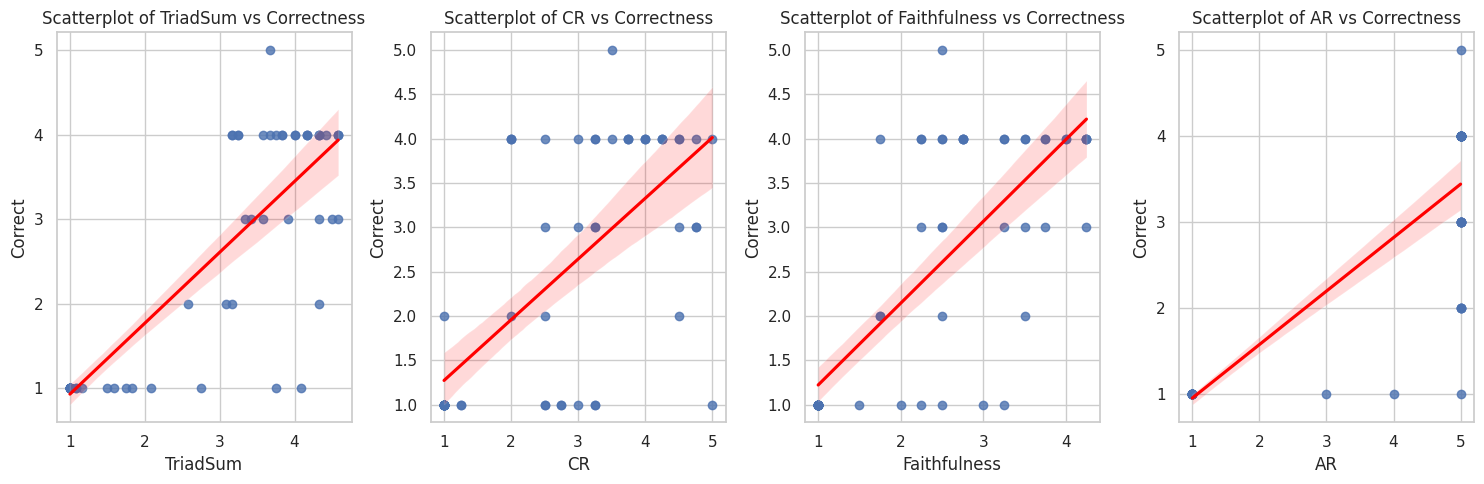

<Figure size 640x480 with 0 Axes>

In [61]:
# Get eval results file names
eval_results_dir = "../eval_results/triad"
eval_results_file_names = get_csv_files_from_dir(eval_results_dir)

# Loop over all eval results files and output the filenames with an index in the dir
for filename in eval_results_file_names[1:2]:  # Iterate over all eval results files
    # Filter files: Only look at files with quExp1_rerank1_cExp*_backRevFalse_numRef4
    # first_file = f"{eval_results_dir}/{eval_results_file_names[1]}"  # Slice for dev
    file = eval_results_dir + "/" + filename  # Slice for dev
    print(f"File: {file}")
    # Read eval results from CSV
    eval_results_df = pd.read_csv(file)
    # Get first 10 rows 
    # eval_results_df = eval_results_df.head(10)
    # print(f"Eval results: {eval_results_df.head()}")
    eval_results_df = add_triad_column(eval_results_df,"average")


    # print(f" eval results columns: {eval_results_df.columns}")    
    eval_results_df[["answer",'ground_truth',"TriadSum","CR","Faithfulness","AR", "Correct"]]
    corr_matrix = eval_results_df[["TriadSum","CR","Faithfulness","AR", "Correct"]].corr("pearson")
    print(corr_matrix)


##
## Examine correlation between TriadSum and Correct
## 

# Heatmap
cmap = sns.diverging_palette(220, 20, as_cmap=True)  # 220 for blue, 20 for red
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Corr Matrix for MiniBiosQA')
plt.savefig(f"../plots/{filename}_corr_matrix.png")
plt.show()
##


# Pair plot to visualize relationships between variables
sns.pairplot(eval_results_df[['TriadSum','CR','Faithfulness','AR','Correct']])
# plt.suptitle('Pair Plot of Variables', y=1.02)
plt.show()
plt.savefig(f"../plots/{filename}_pair_plot.png")
##


# Scatterplot with regression line
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, col in enumerate(['TriadSum', 'CR', 'Faithfulness', 'AR']):
    sns.regplot(x=eval_results_df[col], y=eval_results_df["Correct"], ax=axes[i], line_kws={"color": "red"})
    axes[i].set_title(f'Scatterplot of {col} vs Correctness')

plt.tight_layout()
plt.show()
plt.savefig(f"../plots/{filename}_scatter_plot.png")
##
